In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import os
import sys
from pathlib import Path
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan import data, read_config
from dsrnngan.noise import NoiseGenerator

In [92]:
import yaml
from glob import glob
from dsrnngan.evaluation import setup_inputs
from dsrnngan.data import DATA_PATHS

model_folder='/user/home/uz22147/logs/cgan'

model_weights_root = os.path.join(model_folder, "models")
config_path = os.path.join(model_folder, 'setup_params.yaml')
df_dict = read_config.read_config()['DOWNSCALING']

most_recent_model = sorted(glob(os.path.join(model_weights_root, '*.h5')))[-1]

In [93]:
with open(config_path, 'r') as f:
    try:
        setup_params = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

mode = setup_params["GENERAL"]["mode"]
arch = setup_params["MODEL"]["architecture"]
padding = setup_params["MODEL"]["padding"]
batch_size = 1  # setup_params["TRAIN"]["batch_size"]
fcst_data_source=setup_params['DATA']['fcst_data_source']
obs_data_source=setup_params['DATA']['obs_data_source']
input_channels = setup_params['DATA']['input_channels']
constant_fields = setup_params['DATA']['constant_fields']
input_image_width = setup_params['DATA']['input_image_width']
output_image_width = input_image_width * df_dict['downscaling_factor']
constants_image_width = input_image_width
problem_type = setup_params["GENERAL"]["problem_type"]
downsample = setup_params['GENERAL']['downsample']
filters_gen = setup_params["GENERATOR"]["filters_gen"]
noise_channels = setup_params["GENERATOR"]["noise_channels"]
latent_variables = setup_params["GENERATOR"]["latent_variables"]
filters_disc = setup_params["DISCRIMINATOR"]["filters_disc"]
num_batches = setup_params["EVAL"]["num_batches"]
add_noise = setup_params["EVAL"]["add_postprocessing_noise"]

val_range = setup_params['VAL'].get('val_range')
min_latitude = setup_params['DATA']['min_latitude']
max_latitude = setup_params['DATA']['max_latitude']
latitude_step_size = setup_params['DATA']['latitude_step_size']
min_longitude = setup_params['DATA']['min_longitude']
max_longitude = setup_params['DATA']['max_longitude']
longitude_step_size = setup_params['DATA']['longitude_step_size']
latitude_range=np.arange(min_latitude, max_latitude, latitude_step_size)
longitude_range=np.arange(min_longitude, max_longitude, longitude_step_size)

print('setting up inputs')
gen, batch_gen_valid = setup_inputs(mode=mode,
                                arch=arch,
                                records_folder='/user/work/uz22147/tfrecords/d34d309eb0e00b04',
                                fcst_data_source=fcst_data_source,
                                obs_data_source=obs_data_source,
                                hour=18,
                                latitude_range=latitude_range,
                                longitude_range=longitude_range,
                                downscaling_steps=df_dict["steps"],
                                validation_range=val_range,
                                downsample=downsample,
                                input_channels=input_channels,
                                constant_fields=constant_fields,
                                filters_gen=filters_gen,
                                filters_disc=filters_disc,
                                noise_channels=noise_channels,
                                latent_variables=latent_variables,
                                padding=padding,
                                data_paths=DATA_PATHS)

print('loading weights')
gen.load_weights(most_recent_model)

setting up inputs
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)
upscaled constants shape: (None, None, None, 64)
noise_input shape: (None, None, None, 4)
Shape after first concatenate: (None, None, None, 88)
End of first residual block
Shape after first residual block: (None, None, None, 64)
Shape after upsampling step 1: (None, None, None, 64)
Shape after residual block: (None, None, None, 64)
Shape after second concatenate: (None, None, None, 66)
Shape after third residual block: (None, None, None, 64)
Output shape: (None, None, None, 1)
generator_input shape: (None, None, None, 20)
constants_input shape: (None, None, None, 2)
generator_output shape: (None, None, None, 1)
upscaled constants shape: (None, None, None, 256)
Shape after lo-res concatenate: (None, None, None, 276)
Shape after hi-res concatenate: (None, None, None, 3)
Shape of lo-res input after residual block: (None, None, None, 512)
Shape of hi_res_input after upsampling step 

1/1 [==============================] - 0s 144ms/step
iMERG max:  13.544802
Forecast max:  4.023488610982894
1/1 [==============================] - 0s 144ms/step
iMERG max:  25.142841
Forecast max:  11.217147111892704
1/1 [==============================] - 0s 126ms/step
iMERG max:  4.876175
Forecast max:  3.914162516593934
1/1 [==============================] - 0s 184ms/step
iMERG max:  18.214588
Forecast max:  8.029572665691376
1/1 [==============================] - 0s 116ms/step
iMERG max:  23.192722
Forecast max:  5.31131774187088


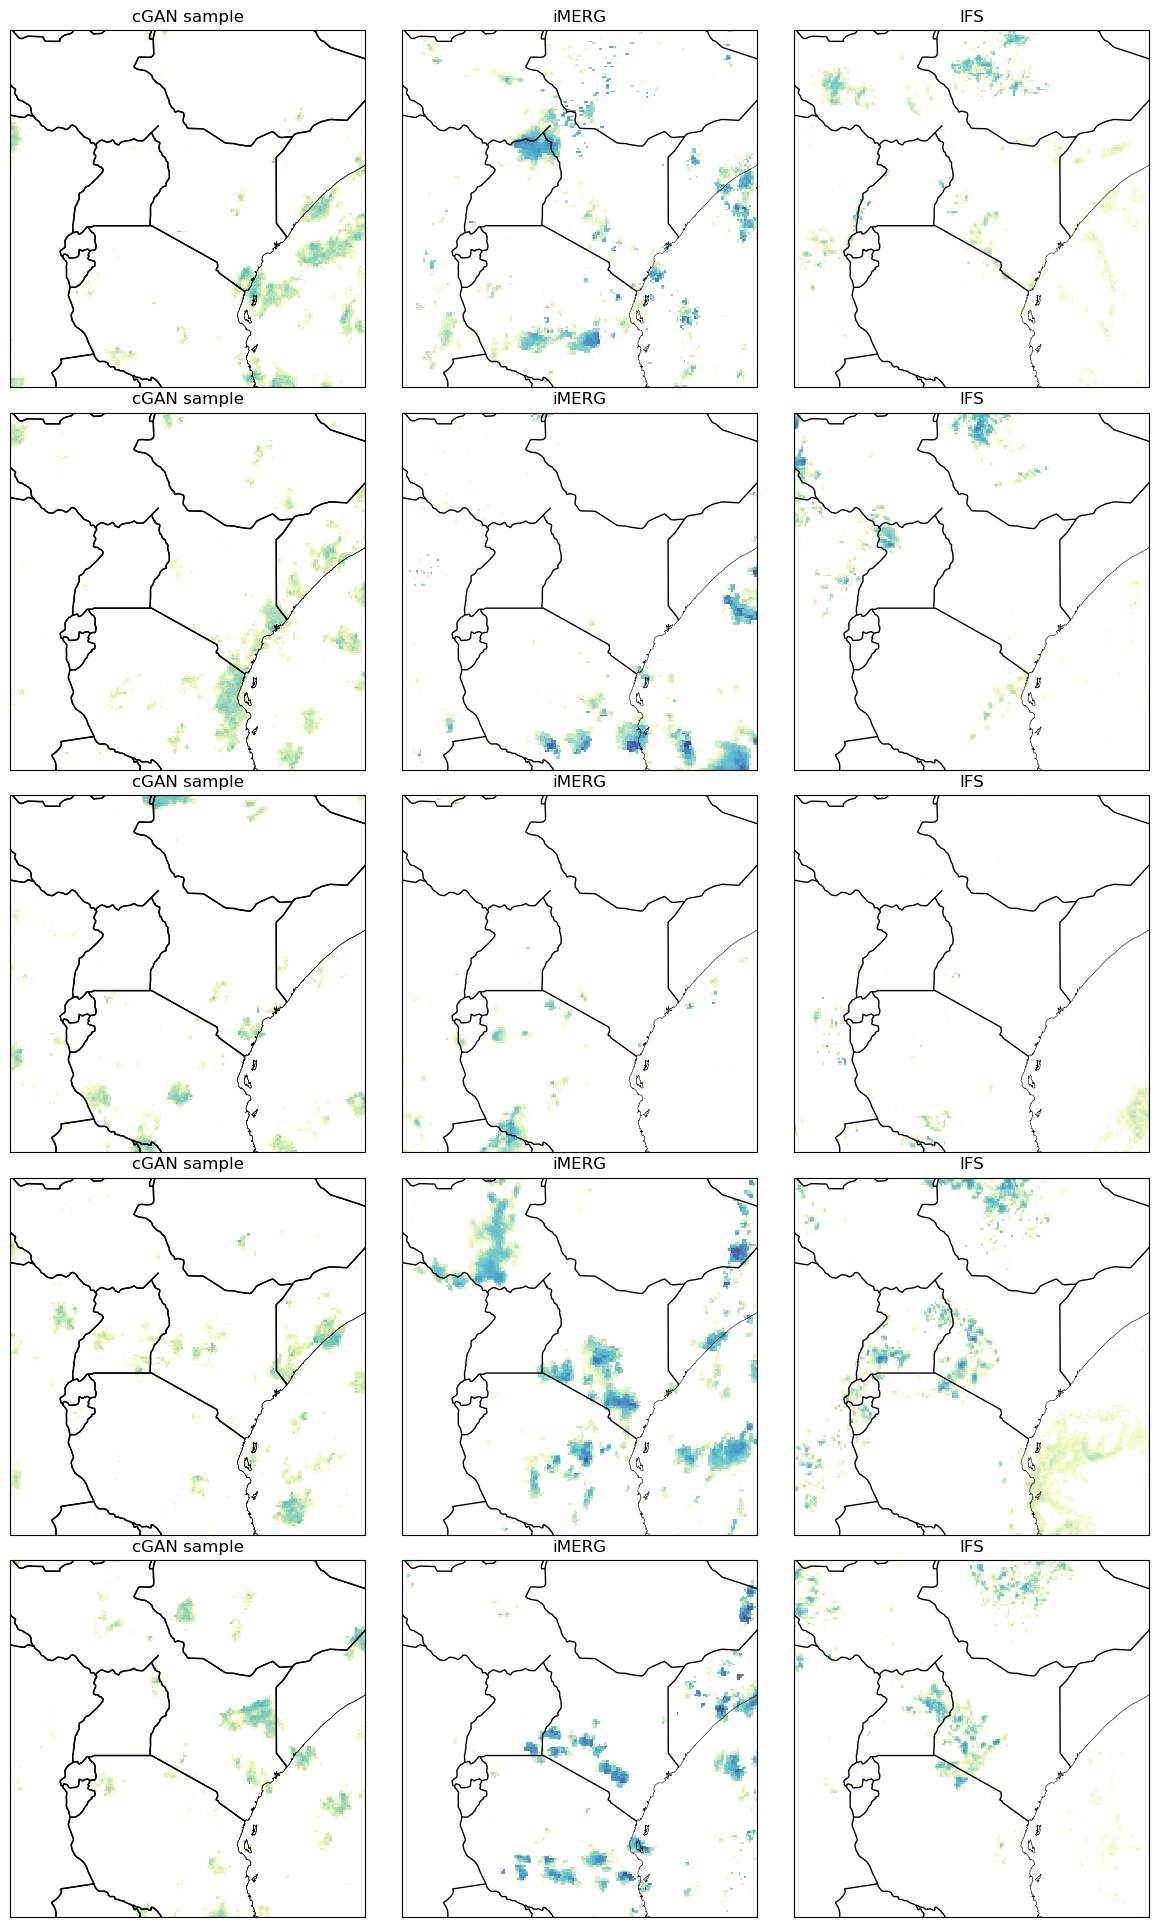

In [102]:
import os
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec

from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_img_log_coastlines
import copy

denormalise_data = True
batch_gen_iter = iter(batch_gen_valid)

tp_index = data.all_ifs_fields.index('tp')
palette="YlGnBu"
linewidth = 0.4
cmap = ListedColormap(sns.color_palette(palette, 256))
cmap.set_under('white')
extent = [min(longitude_range), max(longitude_range), min(latitude_range), max(latitude_range)]
alpha = 0.8
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
cb_tick_loc = np.array([0.1, 0.5, 1, 2, 5, 15, 30, 50])
cb_tick_labels = [0.1, 0.5, 1, 2, 5, 15, 30, 50]
value_range_precip=(0.1, 30)
num_samples = 5
num_rows = num_samples
num_cols = 3

figsize = (num_cols*5, num_rows*5)
plt.figure(figsize=figsize)

gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)

for n in range(num_samples):
    inputs, outputs = next(batch_gen_iter)
    cond = inputs['lo_res_inputs']
    const = inputs['hi_res_inputs']
    truth = outputs['output']
    fcst = copy.copy(cond)
    truth = np.expand_dims(np.array(truth), axis=-1)


    if denormalise_data:
        truth = data.denormalise(truth)
        fcst = data.denormalise(fcst)

    noise_shape = np.array(cond)[0, ..., 0].shape + (noise_channels,)
    noise_gen = NoiseGenerator(noise_shape, batch_size=batch_size)
    img_gen = gen.predict([cond, const, noise_gen()])
    
    k = 0

    plt.subplot(gs[(spacing*n):(spacing+spacing*n), (spacing*k):(spacing+spacing*k)],
                            projection=ccrs.PlateCarree())
    ax = plt.gca()
    ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
    plot_img_log_coastlines(img_gen[0, :,:,0],
                                            value_range_precip=value_range_precip,
                                            cmap=cmap,
                                            extent=extent,
                                            alpha=alpha)
    ax.add_feature(cfeature.BORDERS)
    # ax.add_feature(cfeature.LAKES)
    ax.set_title('cGAN sample')

    k = 0

    plt.subplot(gs[(spacing*n):(spacing+spacing*n), (spacing*k):(spacing+spacing*k)],
                            projection=ccrs.PlateCarree())
    ax = plt.gca()
    ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
    plot_img_log_coastlines(img_gen[0, :,:,0],
                                            value_range_precip=value_range_precip,
                                            cmap=cmap,
                                            extent=extent,
                                            alpha=alpha)
    ax.add_feature(cfeature.BORDERS)
    # ax.add_feature(cfeature.LAKES)
    ax.set_title('cGAN sample')

    ##  iMERG
    k = 1

    plt.subplot(gs[(spacing*n):(spacing+spacing*n), (spacing*k):(spacing+spacing*k)],
                            projection=ccrs.PlateCarree())
    ax = plt.gca()
    ax.add_feature(cfeature.BORDERS)
    # ax.add_feature(cfeature.LAKES)
    ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
    plot_img_log_coastlines(truth[0, :,:,0],
                                            value_range_precip=value_range_precip,
                                            cmap=cmap,
                                            extent=extent,
                                            alpha=alpha)
    print('iMERG max: ', truth[0, :,:,0].max())
    ax.set_title('iMERG')

    ## forecast / reanalysis
    k = 2
    
    plt.subplot(gs[(spacing*n):(spacing+spacing*n), (spacing*k):(spacing+spacing*k)],
                            projection=ccrs.PlateCarree())
    ax = plt.gca()
    ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
    plot_img_log_coastlines(fcst[0, :,:,tp_index],
                                            value_range_precip=value_range_precip,
                                            cmap=cmap,
                                            extent=extent,
                                            alpha=alpha)
    print('Forecast max: ', fcst[0, :,:,tp_index].max())
    ax.add_feature(cfeature.BORDERS)
    # ax.add_feature(cfeature.LAKES)
    ax.set_title('IFS')
plt.savefig('cGAN_samples_IFS.png')